In [37]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt 

## The SIR Model

Our goal will be simulation on the SIR model, a system of three nonlinear differential equations describing disease spread. The system looks as follows:

$$
\begin{aligned}
\frac{dS}{dt} &= -\frac{\beta S I}{N} \\
\frac{dI}{dt} &= \frac{\beta S I}{N} - \gamma I \\
\frac{dR}{dt} &= \gamma I
\end{aligned}
$$

with initial conditions $S(0) = S_{0}$, $I(0) = I_0$ and $R_{0} = R_{0}$ and $N = S(t) + I(t) + R(t) = S_{0} + I_{0} + R_{0} = \text{constant}$. This system describes the the spread of an infectious disease by dividing the population into three groups, Susceptibles $S(t)$, Infectious $I(t)$, and Recovered $R(t)$.
A key assumption of this model is that once a personal transitions from infected to recovered they can no longer become susceptible to disease again.

The SIR model has two constant parameters, $\beta$ and $\gamma$. These parameters do not vary with time and are fixed for the duration of the time interval of the solution. The parameter $\gamma$ is the recovery rate, with units of $\frac{1}{\text{days}}$. For instance $\gamma = 0.2$ would indicate a average duration of illness of $5$ days. $\beta$ is the transmission rate, controlling the average number of people infected by one infected person per unit time.  

## Solutions to the SIR Model

Given a known $\beta,\gamma, S_0, I_0$, and $R_0$ we would like to find a solution to the SIR model, $S(t), I(t)$, and $R(t)$ so we can observe how many people are infected, susceptible, and recovered over the course of time. Unfortunately this system of differential equations admits no closed form expression, there is no way derive $S(t),I(t)$, and $R(t)$ algebraically.

### Numerical Solutions

We instead turn to numerical solutions, the process of approximating solutions to the differential equations using computers. The simplest numerical method for approximating solutions to differential equations is Euler's method. In Euler's method we approximate the derivative using finite differences and derive an update formula as follows. 

First, we will use the compact notation $X(t) = [S(t),I(t),R(t)]^T$ and therefore $\frac{dX}{dt} = f(X(t))$ where $f = [-\frac{\beta S I}{N},\frac{\beta S I}{N} - \gamma I,\gamma I]^T$. Then we use the approximation 

$$
\begin{aligned}
\frac{dX}{dt} \approx \frac{\Delta X(t)}{\Delta t}
\end{aligned}
$$

where we have substituted the concrete time step $\Delta t$ for the infinitesimal time step $dt$. The value of $\Delta t$ controls the error of the approximation as we will see later. The infinitesimal step of $dX$ is similarly replaced with $\Delta X = X(t+\Delta t) - X(t)$. Our finite difference derivative then becomes

$$
\begin{aligned}
\frac{\Delta X(t)}{\Delta t} = \frac{X(t+\Delta t) - X(t)}{\Delta t} = f(X(t)). 
\end{aligned}
$$. 

We can solve this expression for $X(t + \Delta t)$ to obtain an update formula 

$$
\begin{aligned}
X(t + \Delta t) = X(t) + \Delta t \cdot f(X(t)) 
\end{aligned}
$$. 

This formula gives us a recursion relation by which we can obtain an approximate solution to $X(t)$ on a grid of time points $[0,\Delta t, 2\Delta t, \dots]$ given a starting point $X(t_0)$.

## Coding the Numerical Solution in JAX

This section will describe how to program the numerical solution to the differential equation in the auto-differentiation python package JAX. We will first define a class `EulerStepper` that implements a single step of the Euler recursion relation. The class fields will be the time step $\Delta t$ denoted `delta_t` in the code, the function $f(X(t))$, and any parameters, in our case $\beta$ and $\gamma$ in the vector `par`. 

In [38]:
class EulerStepper:
    def __init__(self, delta_t=0.01, *, par = None, func):
        self.delta_t = delta_t
        self.par = par
        self.func = func
    
    def __call__(self, x_prev):
        x_next = x_prev + self.delta_t * self.func(x_prev,self.par)
        return x_next

The dunder method `__call__` will run the following code with the following arguments whenever an instance of `EulerStepper` is called as if it were a function. For example,

In [39]:
stepper = EulerStepper(delta_t = 0.1,par=(0.1),func = lambda x,par:-x)

stepper(0.1)

0.09

advances an Euler approximation to the differential equation $\frac{dX}{dt} = -X$ by one time step `delta_t` starting at $0.1$. 

The Euler approximation to our SIR model solution can be easily implemented using a for loop, 

In [50]:
steps = 1000
delta_t = 0.1
par = (0.3,0.1) #beta,gamma
X0 = jnp.array([100.0,1.0,0.0]) #S_0,I_0,R_0
X = jnp.zeros((steps,X0.shape[0])) #Array to hold solution values

X = X.at[0,:].set(X0) #JAX arrays must be set this way, numpy syntax will not work. 
#In fact, JAX arrays are immutable and so the memory is copied, therefore the assignment is vital. 

def SIR_func(X,par): 
    beta,gamma = par #Unpack parameter tuple
    S,I,R = X #Unpack input array 

    N = S+I+R #Total population

    ## Derivatives ##
    dS = -beta/N * S * I
    dI = beta/N * S * I - gamma * I
    dR = gamma * I

    return jnp.array([dS,dI,dR])

SIRstepper = EulerStepper(delta_t = delta_t, par = par, func = SIR_func)

## Euler solution loop ##
for step in range(1,steps): 
    X_next = SIRstepper(X[step-1,:])
    X = X.at[step,:].set(X_next)

We can now plot the solution using the plotting package matplotlib. For the SIR model, the Euler method actually provides a pretty good approximation to the solution!

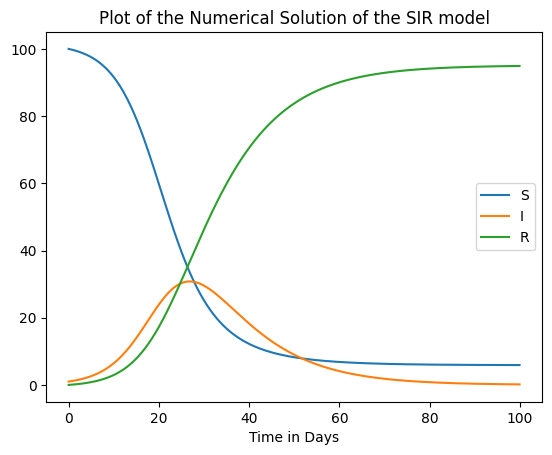

In [51]:
labels = ['S','I','R']
t_range = jnp.arange(0,steps * delta_t,delta_t)

plt.title('Plot of the Numerical Solution of the SIR model')
for i in range(X0.shape[0]): 
    plt.plot(t_range,X[:,i],label = labels[i])

plt.xlabel('Time in Days')
plt.legend()
plt.show()

## Exercises ##

Evaluate the effect of changing `delta_t` on the solution. 

Evaluate the effect of changing $\beta$ and $\gamma$. What happens if $\gamma > \beta$?